https://github.com/ragulpr/wtte-rnn


Задание PRO:

Самостоятельно найти датасет с набором данных GPS сенсора, применить к ним фильтрт Kalmana по аналогии, отрисовать результат сглаживания
Обучить сеть WTT-RNN на данных kaggle соревнования: https://www.kaggle.com/c/LANL-Earthquake-Prediction

In [0]:
from google.colab import drive, files
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!rm ~/.kaggle/kaggle.json

!mkdir ~/.kaggle
!cp /content/drive/My\ Drive/kaggle.json ~/.kaggle
!ls ~/.kaggle

rm: cannot remove '/root/.kaggle/kaggle.json': No such file or directory
kaggle.json


In [0]:
!ls /content/drive/My\ Drive/kaggle.json

ls: cannot access '/content/drive/My Drive/kaggle.json': No such file or directory


#Kalman filter

In [0]:
#данные GPS https://www.openstreetmap.org/traces

#библиотека чтения gpx формата
!pip install gpxpy

#Устанавливаем библиотеку pykalman
!pip install pykalman


     |████████████████████████████████| 112kB 4.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/d2/f0/5e/b8e85979e66efec3eaa0e47fbc5274db99fd1a07befd1b2aa4
Successfully built gpxpy
     |████████████████████████████████| 235kB 4.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/d9/e8/6a/553d9832679cb74a8434fa597c3abdb07313e40054a0adf9ac
Successfully built pykalman


##Read GPS data

In [0]:
import gpxpy 
import gpxpy.gpx 
import numpy as np

#fn = 'drive/My Drive/3055729.gpx'
fn = 'drive/My Drive/3055730.gpx'


gpx_file = open(fn, 'r') 

gpx = gpxpy.parse(gpx_file) 

# Показания GPS датчика
measurements = np.array([])

for track in gpx.tracks: 
  for segment in track.segments: 
    for point in segment.points: 
      measurements = np.concatenate((measurements,[point.latitude, point.longitude]))

measurements = np.reshape(measurements,[len(measurements)//2,2])      

In [0]:
measurements


array([[50.82695333,  4.66964333],
       [50.82692   ,  4.66965   ],
       [50.82691833,  4.66967667],
       ...,
       [50.86526833,  4.69612   ],
       [50.865375  ,  4.69606667],
       [50.86545   ,  4.69603333]])

##Filter

In [0]:
%matplotlib inline
from pykalman import KalmanFilter
import numpy as np
import matplotlib.pyplot as plt
import time


# Начальное приближение (берем первые точки (x,y))
initial_state_mean = [measurements[0, 0],
                      0,
                      measurements[0, 1],
                      0]

# Transition Matrix F (это нулевая первая  производная по динамическому компаненту уравнения изменения x. Например для xt+1 = xt + velocity[t]dt) F = [[1,t],[0,1]]
transition_matrix = [[1, 1, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, 1],
                     [0, 0, 0, 1]]


# Коефициент при показаниях GPS датчика
observation_matrix = [[1, 0, 0, 0],
                      [0, 0, 1, 0]]

# Инициализируем фильтр Калмана
kf1 = KalmanFilter(transition_matrices = transition_matrix,
                   observation_matrices = observation_matrix,
                  initial_state_mean = initial_state_mean)

# На основе данных измерений проводим оценку параметров модели методом EM
kf1 = kf1.em(measurements, n_iter=5)

# Применяем фильтр Калмана к данным для сглаживания кривой
(smoothed_state_means, smoothed_state_covariances) = kf1.smooth(measurements)



##Visualize filter

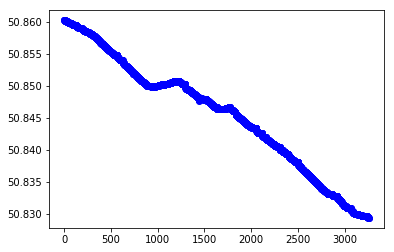

In [0]:
# Рисуем результат сглаживания
plt.figure(1)
times = range(measurements.shape[0])

plt.plot(times, measurements[:, 0], 'bo',
         #times, measurements[:, 1], 'ro',
         times, smoothed_state_means[:, 0], 'b--',
         #times, smoothed_state_means[:, 2], 'r--',
        )
plt.show()

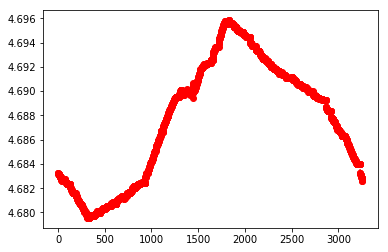

In [0]:
plt.figure(1)
times = range(measurements.shape[0])

plt.plot(times, measurements[:, 1], 'ro',
         times, smoothed_state_means[:, 2], 'r--',)
plt.show()

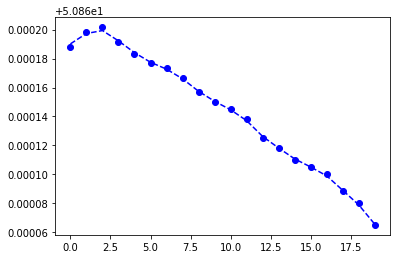

In [0]:
plt.figure(1)
l = 20
times = range(l)
plt.plot(times, measurements[:l, 0], 'bo',
         #times, measurements[:l, 1], 'ro',
         times, smoothed_state_means[:l, 0], 'b--',
         #times, smoothed_state_means[:l, 2], 'r--',
        )
plt.show()

In [0]:
smoothed_state_means[:20, 2]

In [0]:
!ls

#Kaggle

##Load data

In [0]:
!kaggle competitions download -c LANL-Earthquake-Prediction
!unzip test.zip  
!unzip train.csv.zip

In [0]:
import os
import time
import h5py
import numpy as np
import pandas as pd

In [0]:
import pandas as pd
import numpy as np

# Import
float_data = pd.read_csv("train.csv", dtype={"acoustic_data": np.int16, "time_to_failure": np.float32}).values

# Helper function for the data generator. Extracts mean, standard deviation, and quantiles per time step.
# Can easily be extended. Expects a two dimensional array.
def extract_features(z):
     return np.c_[z.mean(axis=1), 
                  z.min(axis=1),
                  z.max(axis=1),
                  z.std(axis=1)]

# For a given ending position "last_index", we split the last 150'000 values 
# of "x" into 150 pieces of length 1000 each. So n_steps * step_length should equal 150'000.
# From each piece, a set features are extracted. This results in a feature matrix 
# of dimension (150 time steps x features).  
def create_X(x, last_index=None, n_steps=150, step_length=1000):
    if last_index == None:
        last_index=len(x)
       
    assert last_index - n_steps * step_length >= 0

    # Reshaping and approximate standardization with mean 5 and std 3.
    temp = (x[(last_index - n_steps * step_length):last_index].reshape(n_steps, -1) - 5 ) / 3
    
    # Extracts features of sequences of full length 1000, of the last 100 values and finally also 
    # of the last 10 observations. 
    return np.c_[extract_features(temp),
                 extract_features(temp[:, -step_length // 10:]),
                 extract_features(temp[:, -step_length // 100:])]

# Query "create_X" to figure out the number of features
n_features = create_X(float_data[0:150000]).shape[1]
print("Our RNN is based on %i features"% n_features)

Our RNN is based on 12 features


##Generator

In [0]:
# Configurable observation look-back period for each engine/day
max_time = 150


# The generator endlessly selects "batch_size" ending positions of sub-time series. For each ending position,
# the "time_to_failure" serves as target, while the features are created by the function "create_X".
def generator(data, min_index=0, max_index=None, batch_size=16, n_steps=150, step_length=1000):
    if max_index is None:
        max_index = len(data) - 1
     
    while True:
        # Pick indices of ending positions
        rows = np.random.randint(min_index + n_steps * step_length, max_index, size=batch_size)
         
        # Initialize feature matrices and targets
        samples = np.zeros((batch_size, n_steps, n_features))
        targets = np.zeros(batch_size, )
        
        for j, row in enumerate(rows):
            samples[j] = create_X(data[:, 0], last_index=row, n_steps=n_steps, step_length=step_length)
            targets[j] = data[row - 1, 1]
        #yield np.asarray(samples,dtype=np.float64), np.asarray(targets,dtype=np.float64)
        yield samples, targets
        
batch_size = 32

# Position of second (of 16) earthquake. Used to have a clean split
# between train and validation
second_earthquake = 50085877
float_data[second_earthquake, 1]

# Initialize generators
train_gen = generator(float_data, batch_size=batch_size) # Use this for better score
# train_gen = generator(float_data, batch_size=batch_size, min_index=second_earthquake + 1)
valid_gen = generator(float_data, batch_size=batch_size, max_index=second_earthquake)


##WTT model

In [0]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense , Bidirectional , GRU, BatchNormalization, Dropout, Lambda
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Masking
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as k
from sklearn.preprocessing import normalize

k.set_epsilon(1e-10)

def weibull_loglik_discrete(y_true, ab_pred, name=None):
    print(y_true)
    print(ab_pred)

    y_ = y_true[:, 0]  
    u_ = 1 #y_true[..., 1]
    a_ = ab_pred[:, 0]
    b_ = ab_pred[:, 1]

    hazard0 = k.pow((y_ + 1e-35) / a_, b_)
    hazard1 = k.pow((y_ + 1) / a_, b_)

    return -1 * k.mean(u_ * k.log(k.exp(hazard1 - hazard0) - 1.0) - hazard1)


def weibull_loglik_continuous(y_true, ab_pred, name=None):
    y_ = y_true[:, 0]
    u_ = y_true[:, 1]
    a_ = ab_pred[:, 0]
    b_ = ab_pred[:, 1]

    ya = (y_ + 1e-35) / a_
    return -1 * k.mean(u_ * (k.log(b_) + b_ * k.log(ya)) - k.pow(ya, b_))
  
"""
    Custom Keras activation function, outputs alpha neuron using exponentiation and beta using softplus
"""
def activate(ab):
    a = k.exp(ab[:, 0])
    b = k.softplus(ab[:, 1])

    a = k.reshape(a, (k.shape(a)[0], 1))
    b = k.reshape(b, (k.shape(b)[0], 1))

    return k.concatenate((a, b), axis=1)

In [0]:
#import wtte.wtte as wtte

# Start building our model
model = Sequential()

# Mask parts of the lookback period that are all zeros (i.e., unobserved) so they don't skew the model
model.add(Masking(mask_value=0., input_shape=(150, 12)))

model.add(BatchNormalization())

model.add(Bidirectional(GRU(64, input_dim=12)))

#model.add(BatchNormalization())

model.add(Dropout(0.3))

# We need 2 neurons to output Alpha and Beta parameters for our Weibull distribution
model.add(Dense(2))

# model.add(Lambda(wtte.output_lambda, 
#                  arguments={"init_alpha":init_alpha, 
#                             "max_beta_value":100.0, 
#                             "alpha_kernel_scalefactor":0.5
#                            },
#                 ))

# # Use the discrete log-likelihood for Weibull survival data as our loss function
# loss = wtte.loss(kind='discrete',reduce_loss=False).loss_function
# model.compile(loss=loss, optimizer=Adam(lr=.01, clipvalue=0.5))


# Apply the custom activation function mentioned above
model.add(Activation(activate))

# Use the discrete log-likelihood for Weibull survival data as our loss function
#model.compile(loss=weibull_loglik_discrete, optimizer=RMSprop(lr=.001), metrics=['mse'])
model.compile(loss=weibull_loglik_discrete, optimizer=Adam(lr=0.01), metrics=['mse'])
#model.compile(optimizer=Adam(lr=0.0005), loss="mae")

model.summary()



##Fit

In [0]:
cb = [ModelCheckpoint("model.hdf5", save_best_only=True, period=3)]

history = model.fit_generator(train_gen,
                              steps_per_epoch=1000,
                              epochs=10,
                              verbose=1,
                              callbacks=cb,
                              validation_data=valid_gen,
                              validation_steps=200
                             )

Epoch 1/10
1000/1000 [==============================] - 1826s 2s/step - loss: 2.5563 - mean_squared_error: 21.3062 - val_loss: 2.3535 - val_mean_squared_error: 14.3409
Epoch 2/10
1000/1000 [==============================] - 957s 957ms/step - loss: 2.4645 - mean_squared_error: 17.9241 - val_loss: 2.4512 - val_mean_squared_error: 17.3683
Epoch 3/10
1000/1000 [==============================] - 913s 913ms/step - loss: 2.4395 - mean_squared_error: 17.3438 - val_loss: 2.3428 - val_mean_squared_error: 13.6762
Epoch 4/10
1000/1000 [==============================] - 714s 714ms/step - loss: 2.7960 - mean_squared_error: 70703.4945 - val_loss: 3.7832 - val_mean_squared_error: 2059.2559
Epoch 5/10
1000/1000 [==============================] - 703s 703ms/step - loss: 3.0796 - mean_squared_error: 9731812.4438 - val_loss: 2.5482 - val_mean_squared_error: 18.7406
Epoch 6/10
1000/1000 [==============================] - 699s 699ms/step - loss: 2.5995 - mean_squared_error: 21.0616 - val_loss: 2.5390 - val_

## Visualize accuracies

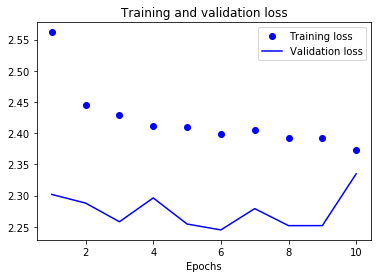

In [0]:

import matplotlib.pyplot as plt

def perf_plot(history, what = 'loss'):
    x = history.history[what]
    val_x = history.history['val_' + what]
    epochs = np.asarray(history.epoch) + 1
    
    plt.plot(epochs, x, 'bo', label = "Training " + what)
    plt.plot(epochs, val_x, 'b', label = "Validation " + what)
    plt.title("Training and validation " + what)
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    return None
  
perf_plot(history)  

##Submission

In [0]:
import tqdm

# Load submission file
submission = pd.read_csv('sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})

# Load each test data, create the feature matrix, get numeric prediction
for i, seg_id in enumerate(tqdm.tqdm(submission.index, position=0)):
  #  print(i)
    seg = pd.read_csv(seg_id + '.csv')    
    x = seg['acoustic_data'].values
    x = np.expand_dims(create_X(x), 0)
    y = model.predict(x)
    #print(y[0][0])
    submission.time_to_failure[i] = y[0][0] #model.predict(np.expand_dims(create_X(x), 0))

submission.head()

# Save
submission.to_csv('submission.csv')

100%|██████████| 2624/2624 [14:12<00:00,  3.08it/s]


In [0]:
!head 'submission.csv'

seg_id,time_to_failure
seg_00030f,4.373146
seg_0012b5,6.514009
seg_00184e,5.824569
seg_003339,6.173629
seg_0042cc,7.515491
seg_004314,4.537914
seg_004cd2,6.4976006
seg_004ee5,6.021864
seg_004f1f,5.3614516


In [0]:
!kaggle competitions submit -c LANL-Earthquake-Prediction -m "Baseline submition from Colab" -f submission.csv

100% 52.4k/52.4k [00:02<00:00, 18.4kB/s]
Successfully submitted to LANL Earthquake Prediction

#Вывод

[colab](https://colab.research.google.com/drive/16iC-DVXdujbp3QYOsK4i0DnHh8_E3ddf)

Протестировал сеть WTT RNN на 128 и 64 ячейки, по 10 эпох.
На вход подавались статистические данные (min, max, mean и std) последовательностей разбитых по 1000, 100, 10 элементов, всего (150,12). 
BatchNormalization обнуляет градиенты, из архитектуры наверно можно еще чтото выжать, сеть долго тренируется на полных данных. Лучший результат дала сеть с GRU(128) на private 1.95197, гдето 2750 место из 4600.